In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [15]:
# Path ke citra
img_path = "data/3/3.10m.png"

#resize witj padding agar jagung tidak terpotong
def resize_with_padding (image, target_size=(224,224)):
    h,w = image.shape
    target_h, target_w = target_size

    scale = min(target_w/w, target_h/h)
    new_w, new_h = int(w * scale), int(h * scale)

    resized = cv2.resize(image, (new_w, new_h))

    top = (target_h - new_h) // 2
    bottom = target_h - new_h - top
    left = (target_w - new_w) // 2
    right = target_w - new_w - left

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=0)

    return padded

# --- BACA DAN RESIZE GAMBAR ---
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# img_resized = cv2.resize(img_gray, (224, 224)) //tanpa padding
img_resized = resize_with_padding(img_gray)

# --- NORMALISASI ---
def normalize(img):
    return img.astype(np.float32) / 255.0

In [16]:
# --- CLAHE ENHANCEMENT ---
def apply_clahe_np(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)
img_clahe = apply_clahe_np(img_resized)
img_clahe_norm = normalize(img_clahe)

# --- SHARPNESS LAPACIAN VARIANCE ---
def laplacian_variance(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()
sharp_before = laplacian_variance(img_resized)
sharp_after = laplacian_variance(img_clahe)
# --- CDF (Cumulative Distribution Function) ---
def compute_cdf(img):
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    return cdf_normalized
cdf_before = compute_cdf(img_resized)
cdf_after = compute_cdf(img_clahe)

# --- OUTPUT NILAI-NILAI ---
print("== LAPORAN PEMROSESAN GAMBAR ==")
print(f"Sharpness (Sebelum CLAHE): {sharp_before:.2f}")
print(f"Sharpness (Setelah CLAHE): {sharp_after:.2f}")

print("\nContoh 10 Nilai CDF Sebelum CLAHE:")
print(np.round(cdf_before[:10].flatten(), 3))

print("\nContoh 10 Nilai CDF Setelah CLAHE:")
print(np.round(cdf_after[:10].flatten(), 3))


== LAPORAN PEMROSESAN GAMBAR ==
Sharpness (Sebelum CLAHE): 21.39
Sharpness (Setelah CLAHE): 23.05

Contoh 10 Nilai CDF Sebelum CLAHE:
[0.997 0.998 0.998 0.998 0.998 0.998 0.999 0.999 0.999 0.999]

Contoh 10 Nilai CDF Setelah CLAHE:
[0.    0.    0.    0.997 0.997 0.998 0.998 0.998 0.998 0.998]


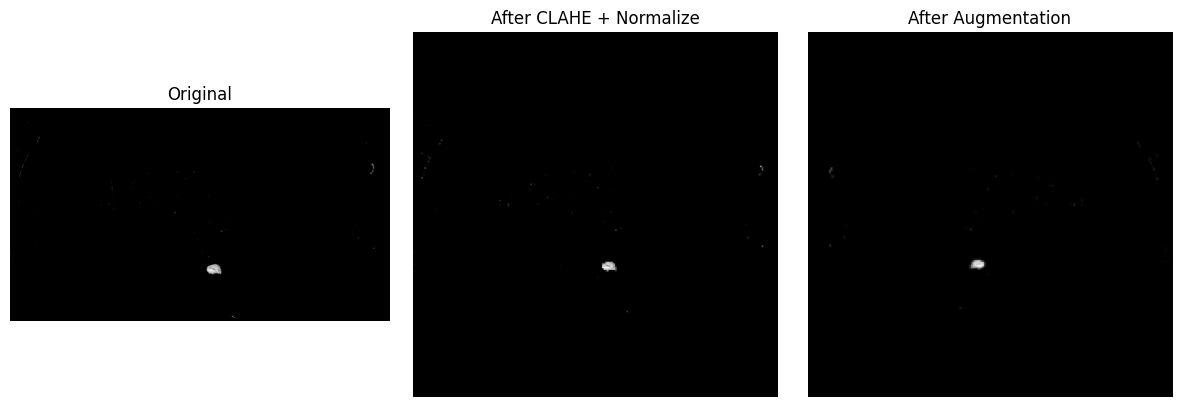

In [17]:
# Augmentasi manual (gunakan sesuai kebutuhan)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.30),
    tf.keras.layers.RandomZoom(0.1),
])

# Pastikan img_clahe_norm bertipe float32 dalam range [0,1]
img_tensor = tf.convert_to_tensor(img_clahe_norm, dtype=tf.float32)

# Tambahkan channel axis: (H, W) -> (H, W, 1)
img_tensor = tf.expand_dims(img_tensor, -1)

# Terapkan augmentasi
augmented_img = data_augmentation(img_tensor)

# Jika ingin menghapus channel (untuk grayscale kembali)
augmented_img = tf.squeeze(augmented_img, axis=-1)  # (H, W)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_clahe_norm, cmap='gray')
plt.title('After CLAHE + Normalize')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(augmented_img.numpy(), cmap='gray')
plt.title('After Augmentation')
plt.axis('off')

plt.tight_layout()
plt.show()


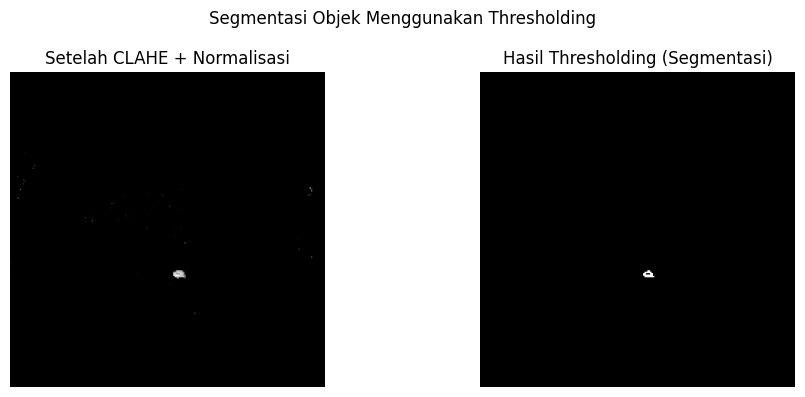

In [23]:
# Ubah ke skala 0–255 karena threshold butuh tipe uint8
img_uint8 = (img_clahe_norm * 255).astype(np.uint8)
_, img_thresh = cv2.threshold(img_uint8, 95, 255, cv2.THRESH_BINARY)

# === Visualisasi Hasil ===
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_uint8, cmap='gray')
plt.title("Setelah CLAHE + Normalisasi")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_thresh, cmap='gray')
plt.title("Hasil Thresholding (Segmentasi)")
plt.axis('off')

plt.suptitle("Segmentasi Objek Menggunakan Thresholding")
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.metrics import jaccard_score
from matplotlib import pyplot as plt

# --- PARAMETER UTAMA ---
output_dir = "hasil_thresholding"
os.makedirs(output_dir + "/original", exist_ok=True)
os.makedirs(output_dir + "/thresholded", exist_ok=True)

# --- BACA DAN RESIZE GAMBAR ---
img = cv2.imread(img_clahe_norm, cv2.IMREAD_GRAYSCALE)
filename_base = os.path.splitext(os.path.basename(img_clahe_norm))[0]

# --- SIMULASI GROUND TRUTH (Jika tidak ada mask manual) ---
# Di sini, kita pakai threshold tetap (127) sebagai simulasi
_, ground_truth = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# --- INISIALISASI LIST HASIL ---
results = []

# --- LOOP BERBAGAI NILAI THRESHOLD ---
for thresh_val in range(50, 201, 25):  # Ubah rentang jika ingin lebih banyak variasi
    _, thresh_img = cv2.threshold(img, thresh_val, 255, cv2.THRESH_BINARY)

    # Simpan hasil gambar
    original_path = f"{output_dir}/original/{filename_base}_{thresh_val}.png"
    thresh_path = f"{output_dir}/thresholded/{filename_base}_{thresh_val}_segmented.png"
    cv2.imwrite(original_path, img)
    cv2.imwrite(thresh_path, thresh_img)

    # --- Evaluasi Jaccard Index ---
    gt_flat = ground_truth.flatten() // 255
    pred_flat = thresh_img.flatten() // 255
    jaccard = jaccard_score(gt_flat, pred_flat)

    # --- Tambahkan ke hasil tabel ---
    results.append({
        "threshold_value": thresh_val,
        "original_image": original_path,
        "thresholded_image": thresh_path,
        "jaccard_index": jaccard
    })

# --- SIMPAN KE CSV ---
df = pd.DataFrame(results)
csv_path = os.path.join(output_dir, "evaluasi_threshold.csv")
df.to_csv(csv_path, index=False)

print(f"Hasil evaluasi disimpan di: {csv_path}")
